# Plotting the Human Microbiome using Principle Component Analysis
### Shane Roesemann


<p>Hello!  

Welcome to my final project for CSCI E-7, Introdction to Programming in Python, via Harvard Extension School. 

In this notebook I will detail how to create a PCA using publicly available OTU (operational taxonomic unit) tables from the HMP (Human Microbiome Project)
</p>

### Background information

<p> Community based microbial studies are increasing in popularity.  This community, called a "microbiome"  offers a huge amount of data for the interaction of the individual bacteria and their hosts, interaction between bacteria, correlations between disease states and community composition, etc.</p>

<p>Many of these studies utilize a sequencing technique called Metagenomic 16S Sequencing.  This technique identifies the components of the community and their relative abundances.  The output is expressed as an OTU table.  OTU tables have the identified bug as the row name, the sample ID as the column name, and the abundance as the intersection.</p>

<p>How does one compare the composition of one sample to another when there could be thousands of bugs?  How do you compare two groups of 50 samples each?  Since there are so many variables here (or dimensions), it is impossible to capture all of this information on a 2D plot.  Therefore, you must use some sort of mathematical process to plot N-dimensional data onto a 2D plane without losing much information.  The process I am describing is a Principle Component Analysis, or PCA.</p>

<p>A PCA does exactly what we need: it takes high-dimensional data (data with many many variables) and plots it into a 2D plane.  The idea is to minimize the information lost, so that the 2D image is still informative about all of the n-dimensions.  Here's roughly how it works:</p>

<p>A vector is drawn on the data that encapsulates the most variation in one dimension.  This is expressed as an eigenvector and is referred to as the "Principle Component". An orthoganal eigenvector is then drawn. This is then repeated for all of the N-dimensions.  The two eigenvectors that encompass the highest variation are the winners and are declared the primary component and the secondary component.  Now each point can be expressed as coordinates on the 1st component and the 2nd component (1st comp, 2nd comp) as you would on a X,Y plane.</p>

<p>Voila, a 2D image representing multidimensional data.  </p>

<p>How to interpret the data:</p>

<p>Points that are close to each other are very similar and points far apart are very different. The X-axis always expresses a higher degree of variation in the dataset.  So points far away on the x-axis are always more different than points equally far away on the y-axis

</p>

<p>Data input:</p>

<p>The dataset I used was a sample dataset that is publicly available from the HMP website (http://www.hmpdacc.org/HMQCP/all/), under "Final OTU table".  I changed the format a little bit while inspecting in a text editor.  I erased the #'s at the beginning of the column names and row names.  Please not this change.  I uploaded the original dataframe to my Github page in a compressed version.  My uncompressed, edited version was too big to upload.</p>

In [361]:
# Libraries used
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA


In [363]:

# Using pandas to create a dataframe
df = pd.read_csv('otu_table_psn_v13.csv', sep='\t')
df = pd.DataFrame(df)


# I only want the relevant data.  There was originally a column
# with the OTU's definition (for example, E.coli).  This messes
# up downstream analysis and so I just deleted this column.

del df['Consensus Lineage']

#check the format of dataframe
#print(df)


# make a subset of the df for a presentation

small_df = df.ix[:4, :4]

print(small_df)

             700110831  700021898  700113546  700016133
OTU_97.1             0          0          0          0
OTU_97.10            0          0          0          0
OTU_97.100           0          0          0          0
OTU_97.1000          0          0          0          0


### Note:  Manual vs. sklearn
<p> You can calculate all the eigenvectors and their associated values and plot them if you'd like, but there is a really easy sklearn module that does this math for us.  It also picks the top two eigenvectors to plot.  That is what I am using here</p>

### Metadata

<p> Now to download the metadata.  This is the type of data that is recorded at the time of sample collection.  Mainly, the person's ID, their gender, and the type of sample (stool, saliva, etc). </p>

<p> This was also found on the HMP website </p>

In [365]:
# imput w/ pandas
meta = pd.read_csv('v13_map_uniquebyPSN.txt', sep='\t')

# check format
# print(meta)

small_meta = meta.ix[:4, :4]
print(small_meta)

   #SampleID       RSID  visitno     sex
0  700013549  158013734        1  female
1  700014386  158398106        1    male
2  700014403  158398106        1    male
3  700014409  158398106        1    male
4  700014412  158398106        1    male


### Subsetting the metadata

<p> Now that we have the OTU table and the metadata, we can do some fun comparisons!  Let's look at the differences in community composition between three body sites:  Stool, saliva, and throat.  </p>

<p>I made three metadata dataframes, subsetted by the bodysite.</p>

In [366]:
meta_stool = (meta.loc[meta['HMPbodysubsite'] == "Stool"])
meta_saliva = (meta.loc[meta['HMPbodysubsite'] == "Saliva"])
meta_throat = (meta.loc[meta['HMPbodysubsite'] == "Throat"])


# check format
# print(meta_stool)


### Subsetting the original df

<p> Now that the metadata is parsed by type, I will make a list of sample ID's corresponding to each type. (ex. a list of stool samples)</p>

<p> Then, I will make three new dataframes pulling all columns that match the list of sample ID's I just created.  This subsets the original df.</p>

In [367]:
import numpy as np

# create a list of sample IDs
stool_list = [str(x) for x in meta_stool['#SampleID']]
saliva_list = [str(x) for x in meta_saliva['#SampleID']]
throat_list = [str(x) for x in meta_throat['#SampleID']]

# subset original df
stool = df.loc[:,stool_list]
saliva = df.loc[:, saliva_list]
throat = df.loc[:, throat_list]

#check format
# print(stool)

### Making our subsets smaller, merging subsets, cleaning data

<p> To prevent my computer from running forever, I subset the subsets (groan...) so that I am taking the first 50 samples from each </p>

<p> Then, I merged the three datasets all together.</p>

<p> I was running into a lot of problems with NaN's in my dataset.  I did a lot of searching and the model we use really doesn't like NaN's.  So I had to clean up the merged dataset to remove NaN's.</p>

In [369]:

# Subset the subsets....
stool2 = stool.ix[:, :50]
saliva2 = saliva.ix[:, :50]
throat2 = throat.ix[:, :50]

# check format
# print(throat2)

# merge subsets
X_stool_saliva = stool2.join(saliva2)
X_stool_saliva_throat = X_stool_saliva.join(throat2)

# check format
#print(X_stool_saliva_throat)

# remove NaN's and replace with 0's
X_stool_saliva_throat = X_stool_saliva_throat.replace(np.nan, 0)

# check format
# print(X_stool_saliva_throat)

### Making Labels

<p> I cannot explain exactly why this is how matlabplot takes in it's sample labels, but this was the only way I could figure out how to do it.  I am going to compare 50 stool samples to 50 salivas to 50 throats.  I had to make a list that had 50 items of "Stool", 50 of "Saliva", etc.  For some reason the model didn't accept these labels until they were in a numpy array.</p>

In [370]:

y_stool = ["Stool" for x in range(0, 50)]
y_saliva = ["Saliva" for x in range(0,50)]
y_throat = ["Throat" for x in range(0,50)]

# merge 
y_stool_saliva_throat = y_stool + y_saliva + y_throat

# convert into a np array
y_stool_saliva_throat = np.array(y_stool_saliva_throat)

# check format
#print(y_stool_saliva_throat)

In [371]:
# This is the actual program to create eigenvectors, 
# eigenvalues, and to pick the best two vectors

X_std = StandardScaler().fit_transform(X_stool_saliva_throat.transpose())
sklearn_pca = sklearnPCA(n_components=150)
Y_sklearn = sklearn_pca.fit_transform(X_std)


### Plot the data!

<p> Now to finally plot the data!  This is where our label list comes into play.</p>

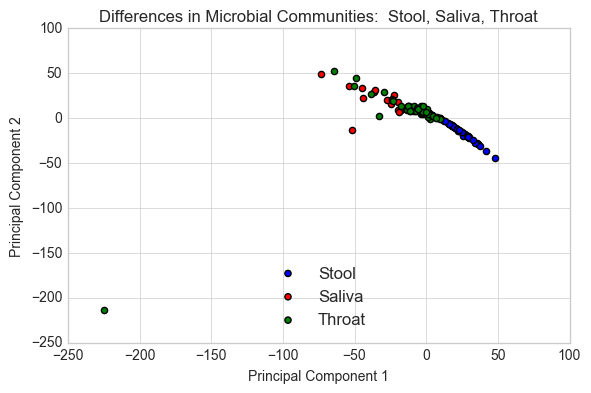

In [372]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Stool', 'Saliva', 'Throat'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y_stool_saliva_throat==lab,0],
                    Y_sklearn[y_stool_saliva_throat==lab,1],
                    c=col,
                   label=lab)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.title('Differences in Microbial Communities:  Stool, Saliva, Throat')
    plt.tight_layout()
    plt.show()

### Analysis!!!

<p>There seems to be a definite difference in each sample type's composition.  They cluster somewhat close to each other based on sample type.</p>

<p> I know that my python skills are working in this context because the intuitive seems to be correct: Saliva and throat samples are more closely related than saliva and stool</p>

<p> Lastly, I have a priori knowledge that interindividual variance is really high in these studies, so weak clustering was kind of expected.</p>

### One.... More.... TIME!!!!!

<p> Let's repeat that whole process to see if there is a difference between male and female, across all body sites.</p>

In [373]:
meta_male = (meta.loc[meta['sex'] == "male"])
meta_female = (meta.loc[meta['sex'] == "female"])

male_list = [str(x) for x in meta_male['#SampleID']]
female_list = [str(x) for x in meta_female['#SampleID']]

# subset original df
male = df.loc[:, male_list]
female = df.loc[:, female_list]
# check format
# print(male)

# subset subsets... :(
male2 = male.ix[:, :50]
female2 = female.ix[:, :50]


# merge subsets
X_male_female = male2.join(female2)

# clean df
X_male_female.replace(np.nan, 0)
#print(X_male_female)

# make labels
y_male = ["Male" for x in range(0,50)]
y_female = ["Female" for x in range(0,50)]

# merge labels
y_male_female = y_male + y_female
# make into np.array
y_male_female = np.array(y_male_female)

# check format
# print(y_male_female)

In [374]:
# Run PCA
X_std = StandardScaler().fit_transform(X_male_female.transpose())
sklearn_pca = sklearnPCA(n_components=100)
Y_sklearn = sklearn_pca.fit_transform(X_std)


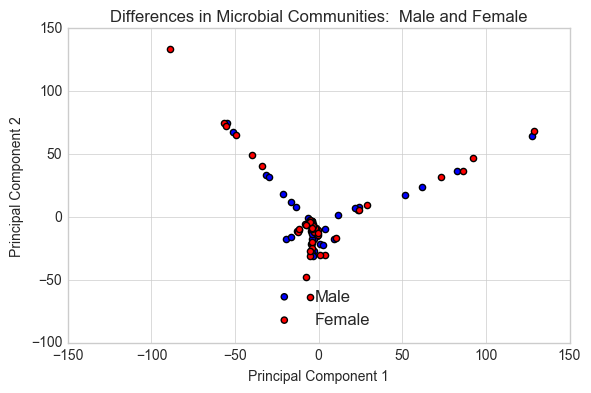

In [375]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Male', 'Female'),
                        ('blue', 'red')):
        plt.scatter(Y_sklearn[y_male_female==lab,0],
                    Y_sklearn[y_male_female==lab,1],
                    c=col,
                   label=lab)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.title('Differences in Microbial Communities:  Male and Female')
    plt.tight_layout()
    plt.show()

### Analysis!!!!!

<p> Weird!!!!  It is sadfe to say that there is little difference between males and females.  It can also be said that there is a high degree of interindividual variance among both sexes.</p>

<p> My initial reaction was that this graph was not constructed correctly.  I am still skeptical of this representation, but my first PCA was as expected, so I am inclined to take this as accurate.</p>